In [1]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Attention, Flatten
from tensorflow.keras.models import Model
import time

## Heston Model

In [2]:
def simulate_heston_model(mu, kappa, theta, sigma, rho, T, N, S0, v0):
    dt = T / N
    prices = np.zeros(N)
    variance = np.zeros(N)

    prices[0] = S0
    variance[0] = v0

    for t in range(1, N):
        wt = np.random.normal(0, np.sqrt(dt))
        wv = rho * wt + np.sqrt(1 - rho ** 2) * np.random.normal(0, np.sqrt(dt))

        variance[t] = np.abs(variance[t - 1] + kappa * (theta - variance[t - 1]) * dt + sigma * np.sqrt(variance[t - 1]) * wv)
        prices[t] = prices[t - 1] * np.exp((mu - 0.5 * variance[t]) * dt + np.sqrt(variance[t]) * wt)

    return prices, variance

In [3]:
mu = 0.05
kappa = 1.5
theta = 0.04
sigma = 0.3
rho = -0.6
T = 1.0
N = 252
S0 = 100
v0 = 0.04
time_ = list(range(1, N+1))

In [4]:
stock_prices, variances = simulate_heston_model(mu, kappa, theta, sigma, rho, T, N, S0, v0)

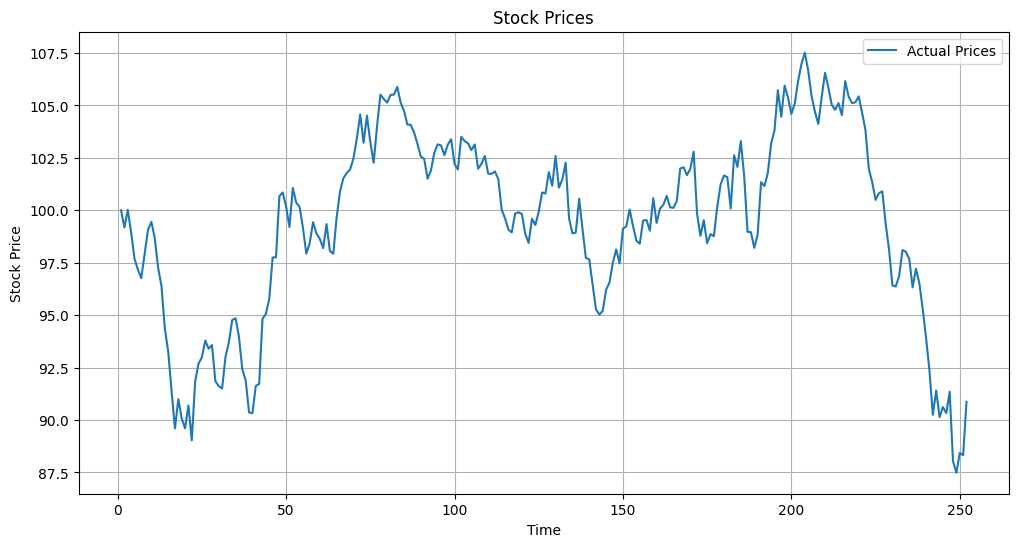

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(time_,  stock_prices, label='Actual Prices')
plt.title('Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
log_stock_prices = np.log(stock_prices)

## Neural Network to Fitting data with MLP

Test loss: 20.732513427734375
8/8 [==============================] - 0s 1ms/step


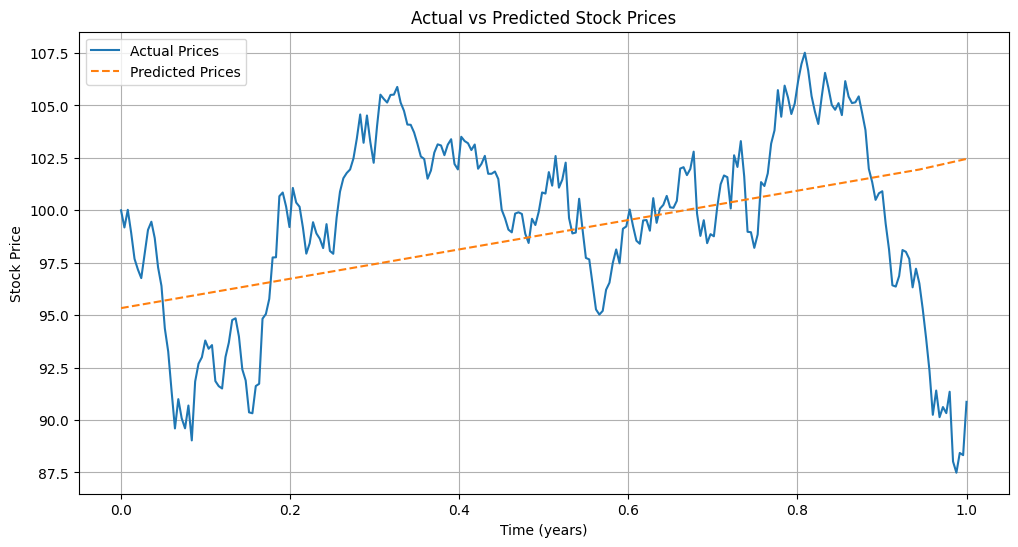

In [7]:
time_steps = np.linspace(0, T, N).reshape(-1, 1)


model = Sequential([
    Dense(128, activation='relu', input_shape=(1,)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(time_steps, stock_prices, epochs=100, batch_size=16, validation_split=0.2, verbose=0)

# Evaluate the model
loss = model.evaluate(time_steps, stock_prices, verbose=0)
print(f"Test loss: {loss}")

# Predictions
predictions = model.predict(time_steps)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time_steps,  stock_prices, label='Actual Prices')
plt.plot(time_steps, predictions, label='Predicted Prices', linestyle='dashed')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


## Neural Network to Fitting data with LSTM, Attention in MLP

In [8]:
input_shape = (1, time_steps.shape[1])
inputs = Input(shape=input_shape)

lstm_out = LSTM(128, return_sequences=True)(inputs)
query = lstm_out
value = lstm_out
attention_output = Attention()([query, value])
flattened_output = Flatten()(attention_output)
dense1 = Dense(64, activation='relu')(flattened_output)
dropout = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout)
final_output = Dense(1)(dense2)


model = Model(inputs=inputs, outputs=final_output)
model.compile(optimizer='adam', loss='mean_squared_error')


time_steps_3D = time_steps.reshape((time_steps.shape[0], 1, time_steps.shape[1]))


history = model.fit(time_steps_3D, stock_prices, epochs=200, batch_size=32, validation_split=0.2, verbose=1)

loss = model.evaluate(time_steps_3D, stock_prices, verbose=0)
print(f"Test loss: {loss}")

Epoch 1/200
7/7 [==============================] - 2s 67ms/step - loss: 9898.1602 - val_loss: 9862.8330
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 9882.4834 - val_loss: 9838.4131
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 9860.0166 - val_loss: 9800.4609
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 9828.0771 - val_loss: 9741.5576
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 9775.6787 - val_loss: 9650.9121
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 9697.1719 - val_loss: 9515.4863
Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 9579.1650 - val_loss: 9314.6582
Epoch 8/200
7/7 [==============================] - 0s 6ms/step - loss: 9410.1631 - val_loss: 9023.2627
Epoch 9/200
7/7 [==============================] - 0s 7ms/step - loss: 9171.9062 - val_loss: 8614.3789
Epoch 10/200
7/7 [==============================] - 0s 7ms/step - loss: 

8/8 [==============================] - 0s 2ms/step


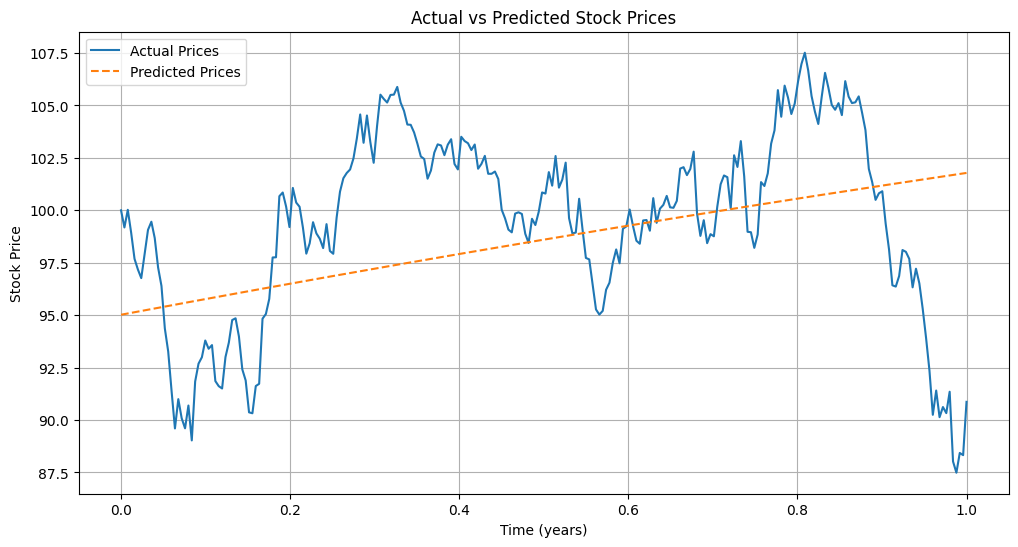

In [9]:
predictions_lstm = model.predict(time_steps)
plt.figure(figsize=(12, 6))
plt.plot(time_steps,  stock_prices, label='Actual Prices')
plt.plot(time_steps, predictions_lstm, label='Predicted Prices', linestyle='dashed')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

## Extend Kalman Filter in Heston

In [10]:
def estimate_extended_kalman_heston(log_stock_prices, N, muS, omega, theta, xi, rho):
    n_stock_prices = len(log_stock_prices)
    delt = 1.0 / N
    eps = 0.00001
    x = 0.04
    P = 0.01

    u = np.zeros(n_stock_prices)
    v = np.ones(n_stock_prices)
    estimates = np.zeros(n_stock_prices)
    u[0] = u[-1] = 0.0
    v[0] = v[-1] = 1.0
    estimates[0] = estimates[1] = log_stock_prices[0] + eps
    likelihood = 0

    for i1 in range(1, n_stock_prices - 1):
        if x < 0:
            x = 0.00001


        x1 = x + (omega - rho * xi * muS - (theta - 0.5 * rho * xi) * x) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1 - 1])
        x1 = np.clip(x1, -1e6, 1e6)
        A = 1.0 - (theta - 0.5 * rho * xi) * delt
        rho = np.clip(rho, -1, 1)
        W = xi * np.sqrt((1 - rho ** 2) * x * delt)
        P1 = W ** 2 + A * P * A

        if x1 < 0:
            x1 = 0.00001

        H = -0.5 * delt
        U = np.sqrt(x1 * delt)
        K = P1 * H / (H * P1 * H + U ** 2)
        z = log_stock_prices[i1 + 1]
        x_update = x1 + K * (z - (log_stock_prices[i1] + (muS - 0.5 * x1) * delt))
        x = np.clip(x_update, -1e6, 1e6)

        u[i1] = z - (log_stock_prices[i1] + (muS - 0.5 * x1) * delt)
        v[i1] = H * P1 * H + U ** 2

        likelihood_term = np.log(v[i1]) + np.log(u[i1]**2) / v[i1]
        likelihood += np.clip(likelihood_term, -1e6, 1e6)

        estimates[i1 + 1] = log_stock_prices[i1] + (muS - 0.5 * x1) * delt
        P = (1.0 - K * H) * P1

    return u, v, estimates, likelihood

In [11]:
u, v, estimates, likelihood = estimate_extended_kalman_heston(log_stock_prices, N, mu, kappa, theta, sigma, rho)

In [13]:
def negative_log_likelihood(params):
    mu, kappa, theta, sigma, rho = params
    u, v, estimates, like = estimate_extended_kalman_heston(log_stock_prices, N, mu, kappa, theta, sigma, rho)
    likelihood = sum(np.log(v[i]) + (u[i]**2) / v[i] for i in range(len(u)))
    if np.isscalar(likelihood):
        return -likelihood
    else:
        return -np.sum(likelihood)

In [14]:
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

1.0663651218849413

In [15]:
result = minimize(negative_log_likelihood, x0=[mu, kappa, theta, sigma, rho],bounds =[[0,1], [1,2], [0, 0.5],[0, 0.5], [-1, 0]] , method="L-BFGS-B",tol=1e-12)

In [16]:
result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1413.9146138143385
        x: [ 1.000e+00  2.000e+00  0.000e+00  0.000e+00  0.000e+00]
      nit: 1
      jac: [-5.604e+00 -1.065e+02  6.257e+01  0.000e+00 -0.000e+00]
     nfev: 12
     njev: 2
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

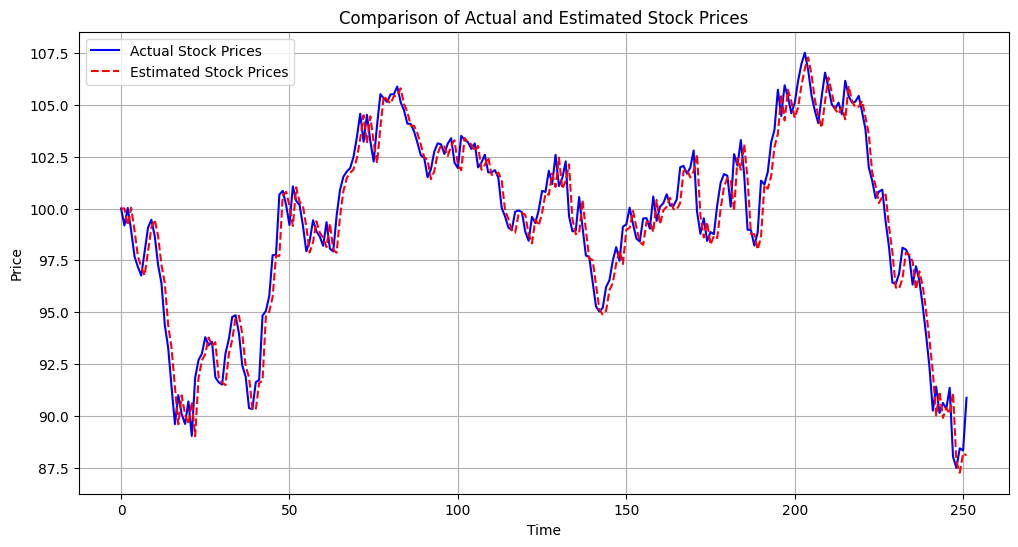

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(stock_prices, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()



In [18]:
guess_mu = 0.1
guess_kappa = 1.0
guess_theta = 0
guess_sigma = 0.1
guess_rho = 0

In [19]:
time_start = time.time()
u, v, estimates, likelihood = estimate_extended_kalman_heston(log_stock_prices, N, guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho)
time_end = time.time()
print("running time (s):    ", time_end-time_start)

running time (s):     0.0188596248626709


In [20]:
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

1.0623146545906048

In [21]:
result = minimize(negative_log_likelihood, x0=[guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho],bounds =[[0,1], [1,2], [0, 0.5],[0, 0.5], [-1, 0]] , method="L-BFGS-B",tol=1e-12)

In [22]:
result

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1413.9146138143385
        x: [ 1.000e+00  2.000e+00  0.000e+00  0.000e+00  0.000e+00]
      nit: 1
      jac: [-5.604e+00 -1.065e+02  6.257e+01  0.000e+00 -0.000e+00]
     nfev: 12
     njev: 2
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

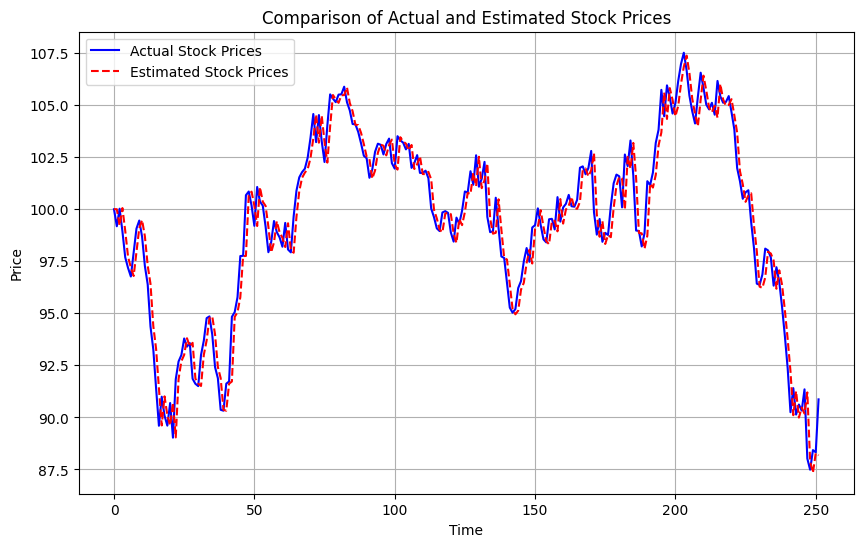

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(stock_prices, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

#### Test other parameter to see robustness

In [24]:
mu = 0.01
kappa = 1.0
theta = 0.02
sigma = 0.1
rho = -0.8
T = 1.0
N = 252
S0 = 100
v0 = 0.04
time_ = list(range(1, N+1))

In [25]:
stock_prices, variances = simulate_heston_model(mu, kappa, theta, sigma, rho, T, N, S0, v0)
log_stock_prices = np.log(stock_prices)

In [26]:
u, v, estimates, likelihood = estimate_extended_kalman_heston(log_stock_prices, N, guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho)

In [27]:
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

1.289759132628777

In [29]:
mu = 0.3
kappa = 2.0
theta = 0.01
sigma = 0.6
rho = -0.1
T = 1.0
N = 252
S0 = 100
v0 = 0.04
time_ = list(range(1, N+1))

stock_prices, variances = simulate_heston_model(mu, kappa, theta, sigma, rho, T, N, S0, v0)
log_stock_prices = np.log(stock_prices)
u, v, estimates, likelihood = estimate_extended_kalman_heston(log_stock_prices, N, guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho)
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

0.5457460610404794

In [30]:
mu = 0.23
kappa = 0.01
theta = 3
sigma = 0.2
rho = 0
T = 1.0
N = 252
S0 = 100
v0 = 0.04
time_ = list(range(1, N+1))

stock_prices, variances = simulate_heston_model(mu, kappa, theta, sigma, rho, T, N, S0, v0)
log_stock_prices = np.log(stock_prices)
u, v, estimates, likelihood = estimate_extended_kalman_heston(log_stock_prices, N, guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho)
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

2.084869346249346

## Particle Extend Kalman Filter in Heston

In [31]:
def particle_extended_kalman_heston(log_stock_prices, muS, omega, theta, xi, rho):
    n_stock_prices = len(log_stock_prices)
    M = 1000
    delt = 1.0 / 252.0
    A = 1.0 - (theta - 0.5 * rho * xi) * delt
    H = -0.5 * delt
    x0 = 0.04
    P0 = 0.000001
    x = x0 + np.sqrt(P0) * np.random.normal(size=M)
    P = np.full(M, P0)
    ll = 0.0
    estimates = np.zeros(n_stock_prices)
    epsilon = 1e-10  # A small constant to prevent division by zero

    for i1 in range(1, n_stock_prices - 1):
        l = 0.0
        x1_sum = 0.0
        x1, x2, xx, W, P1, U, K, w = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)

        for i2 in range(M):
            if x[i2] < 0:
                x[i2] = 0.00001

            x1[i2] = x[i2] + (omega - rho * xi * muS - (theta - 0.5 * rho * xi) * x[i2]) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1 - 1])
            W[i2] = xi * np.sqrt((1 - rho ** 2) * x[i2] * delt)
            P1[i2] = W[i2] ** 2 + A * P[i2] * A

            if x1[i2] < 0:
                x1[i2] = 0.00001

            U[i2] = np.sqrt(x1[i2] * delt)
            K[i2] = P1[i2] * H / (H * P1[i2] * H + U[i2] ** 2)
            z = log_stock_prices[i1 + 1]
            x2[i2] = x1[i2] + K[i2] * (z - (log_stock_prices[i1] + (muS - 0.5 * x1[i2]) * delt))
            x1_sum += x1[i2]
            P[i2] = (1.0 - K[i2] * H) * P1[i2]
            xx[i2] = x2[i2] + np.sqrt(P[i2]) * np.random.normal()

            if xx[i2] < 0:
                xx[i2] = 0.00001

            m = x2[i2]
            s = max(np.sqrt(P[i2]), epsilon)
            q = stats.norm.pdf(xx[i2], loc=m, scale=s)
            m = log_stock_prices[i1] + (muS - 0.5 * xx[i2]) * delt
            s = max(np.sqrt(xx[i2] * delt), epsilon)
            pz = stats.norm.pdf(z, loc=m, scale=s)
            m = x[i2] + (omega - rho * xi * muS - (theta - 0.5 * rho * xi) * x[i2]) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1 - 1])
            s = max(xi * np.sqrt((1 - rho ** 2) * x[i2] * delt), epsilon)
            px = stats.norm.pdf(xx[i2], loc=m, scale=s)
            w[i2] = pz * px / max(q, 1.0e-10)
            l += w[i2]

        ll += np.log(l)
        estimates[i1 + 1] = log_stock_prices[i1] + (muS - 0.5 * x1_sum / M) * delt
        w /= l
        # resample and reset weights
        c = np.cumsum(w)
        u = np.linspace(1.0 / M, 1, M) - np.random.uniform(0, 1.0 / M)
        indices = np.searchsorted(c, u, side='right') - 1
        indices = np.clip(indices, 0, M-1)
        x, w = xx[indices], np.full(M, 1.0 / M)

    ll *= -1.0  # ll is result for the likelihood function, able to minimize it to get parameter
    initial_params = [muS, omega, theta, xi, rho]

    return ll, estimates


In [32]:
ll, estimates = particle_extended_kalman_heston(log_stock_prices, mu, kappa, theta, sigma, rho)

In [33]:
def negative_particle_likelihood(params):
    mu, kappa, theta, sigma, rho = params
    ll, estimates = particle_extended_kalman_heston(log_stock_prices, mu, kappa, theta, sigma, rho)
    likelihood = ll
    if np.isscalar(likelihood):
        return -likelihood
    else:
        return -np.sum(likelihood)

In [34]:
# Need to many time, make sure you have enough patient to wait
#result= minimize(negative_particle_likelihood, x0=[mu, kappa, theta, sigma, rho],bounds =[[0,1], [1,2], [0, 0.5],[0, 0.5], [-1, 0]] , method="L-BFGS-B",tol=1e-12)

In [35]:
#result

In [36]:
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

9.101717223841096

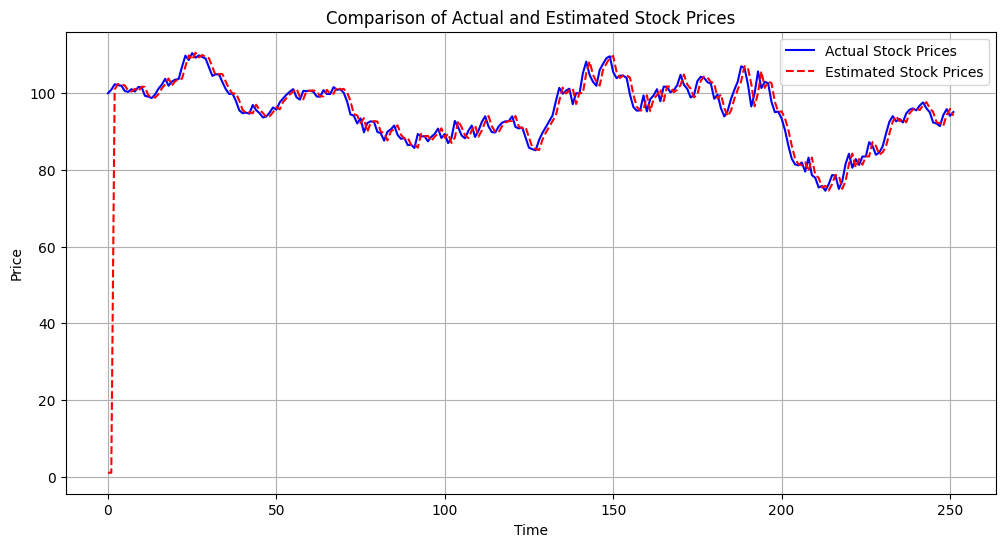

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(stock_prices, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
guess_mu = 0.1
guess_kappa = 1.0
guess_theta = 0
guess_sigma = 0.1
guess_rho = 0

In [39]:
time_start = time.time()
ll, estimates = particle_extended_kalman_heston(log_stock_prices, guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho)
time_end = time.time()
print("Running time (s): ", time_end - time_start)

Running time (s):  100.37145805358887


In [40]:
rmse = np.sqrt(mean_squared_error(stock_prices, np.exp(estimates)))
rmse

9.101104951801544

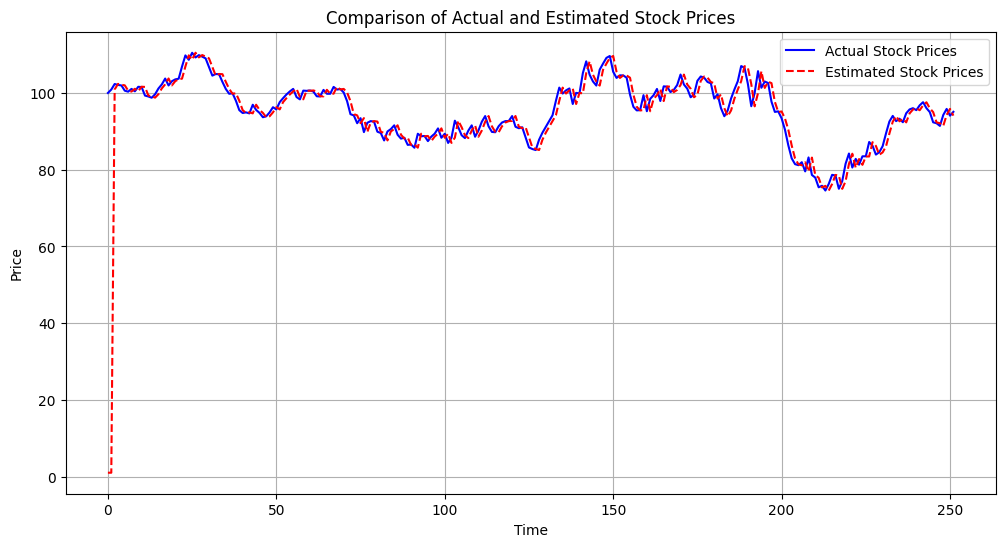

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(stock_prices, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Bates Model (Add Merton log-normal jump to Heston Model)

In [42]:
def simulate_bates_model(S0, mu, v0, rho, kappa, theta, xi, lambda_jump, alpha, delta, T, N):
    dt = T / N  # time increment
    S = np.zeros(N)
    v = np.zeros(N)
    S[0] = S0
    v[0] = v0

    for t in range(1, N):

        Z1 = np.random.normal(0, np.sqrt(dt))
        Z2 = np.random.normal(0, np.sqrt(dt))
        Z2 = rho * Z1 + np.sqrt(1 - rho ** 2) * Z2

        # Check for jumps
        if np.random.poisson(lambda_jump * dt) > 0:
            J = np.exp(alpha + delta * np.random.normal()) - 1
        else:
            J = 0

        v[t] = v[t-1] + kappa * (theta - max(v[t-1], 0)) * dt + xi * np.sqrt(max(v[t-1], 0)) * Z2
        S[t] = S[t-1] * (1 + mu * dt + np.sqrt(max(v[t-1], 0)) * Z1 + J)

    return S, v

In [43]:
S0 = 100        # Initial stock price
mu = 0.05       # Expected return
v0 = 0.04       # Initial variance
rho = -0.6      # Correlation between stock and variance
kappa = 1.5     # Speed of mean reversion
theta = 0.04    # Long-term variance
xi = 0.3        # Volatility of volatility
lambda_jump = 1 # Intensity of the Poisson jump process
alpha = -0.1    # Mean of log-normal jump size
delta = 0.1     # Standard deviation of log-normal jump size
T = 1.0         # Total time
N = 252         # Number of steps
time_ = list(range(1, N+1))

In [44]:
Stock_price_jump, Variance_price_jump = simulate_bates_model(S0, mu, v0, rho, kappa, theta, xi, lambda_jump, alpha, delta, T, N)

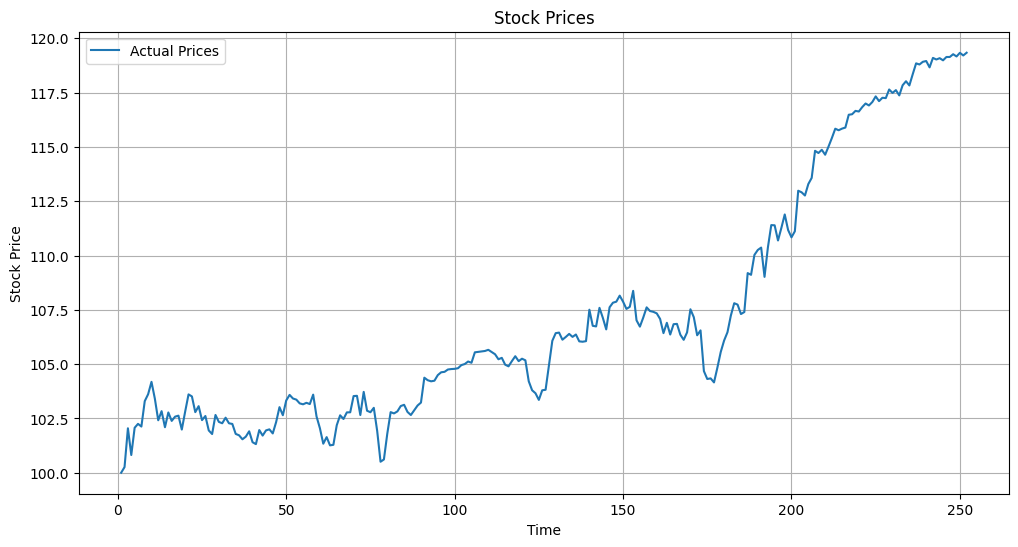

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(time_,  Stock_price_jump, label='Actual Prices')
plt.title('Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
log_stock_prices = np.log(Stock_price_jump)

## Solve Extend Kalman Filter in Bates

In [47]:
# Negative log-likelihood function
def negative_log_likelihood_bates(params, u, v):
    muS, omega, theta, xi, rho, lambda_, sigma_J = params
    n = len(u)
    likelihood = sum(np.log(v[i]) + (u[i]**2) / v[i] for i in range(n))
    return -likelihood

In [48]:
def extended_kalman_parameters_bates(log_stock_prices, N, muS, omega, theta, xi, rho, lambda_, j):
    n_stock_prices = len(log_stock_prices)
    delt = 1.0 / N
    eps = 0.00001
    x = 0.04
    P = 0.01
    u = np.zeros(n_stock_prices)  # Residuals
    v = np.ones(n_stock_prices)   # Residual variances
    estimates = np.zeros(n_stock_prices)
    estimates[0] = log_stock_prices[0] + eps
    likelihood = 0

    for i1 in range(1, n_stock_prices - 1):
        if x < 0:
            x = 0.00001

        # Include the jump term in the state update
        jump_diff = -lambda_ * j * delt if np.random.rand() < 1 - np.exp(-lambda_ * delt) else 0

        # State prediction
        x1 = x + (omega - rho * xi * muS - (theta - 0.5 * rho * xi) * x) * delt + jump_diff
        A = 1.0 - (theta - 0.5 * rho * xi) * delt
        W = xi * np.sqrt((1 - rho ** 2) * x * delt)
        P1 = W ** 2 + A * P * A

        if x1 < 0:
            x1 = 0.00001

        # Measurement update
        H = -0.5 * delt
        U = np.sqrt(x1 * delt)
        K = P1 * H / (H * P1 * H + U ** 2)
        z = log_stock_prices[i1 + 1]
        x_update = x1 + K * (z - (log_stock_prices[i1] + (muS - 0.5 * x1) * delt))

        u[i1] = z - (log_stock_prices[i1] + (muS - 0.5 * x_update) * delt)
        v[i1] = H * P1 * H + U ** 2

        likelihood_term = np.log(v[i1]) + np.log(u[i1]**2) / v[i1]
        likelihood += np.clip(likelihood_term, -1e6, 1e6)

        estimates[i1 + 1] = log_stock_prices[i1] + (muS - 0.5 * x_update) * delt
        P = (1.0 - K * H) * P1

        # Update the state with the measurement update
        x = x_update

    return u, v, estimates, likelihood

In [52]:
lambda_ = 10
j = 0.1

In [53]:
u, v, estimates, like = extended_kalman_parameters_bates(log_stock_prices, N, mu, kappa, theta, xi, rho, lambda_ = 5, j = 0.2)

In [54]:
rmse = np.sqrt(mean_squared_error(Stock_price_jump, np.exp(estimates)))
rmse

6.28053884134327

In [55]:
def negative_log_jump_likelihood(params):
    mu, kappa, theta, sigma, rho, lambda_, J = params
    u, v, estimates, like = extended_kalman_parameters_bates(log_stock_prices, N, mu, kappa, theta, xi, rho, lambda_, j)
    likelihood = sum(np.log(v[i]) + (u[i]**2) / v[i] for i in range(len(u)))
    if np.isscalar(likelihood):
        return -likelihood
    else:
        return -np.sum(likelihood)

In [56]:
result = minimize(negative_log_jump_likelihood, x0=[mu, kappa, theta, sigma, rho, 5, 0.2],bounds =[[0,1], [1,2], [0, 0.5],[0, 0.5], [-1, 0], [4,6],[0,0.5]] , method="L-BFGS-B",tol=1e-12)

In [57]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1502.3249304679266
        x: [ 5.000e-02  1.500e+00  4.000e-02  2.000e-01 -6.000e-01
             5.000e+00  2.000e-01]
      nit: 3
      jac: [ 9.228e+07  2.173e+08  1.832e+08 -3.029e+07  5.610e+07
            -5.089e+06  2.262e+08]
     nfev: 192
     njev: 24
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

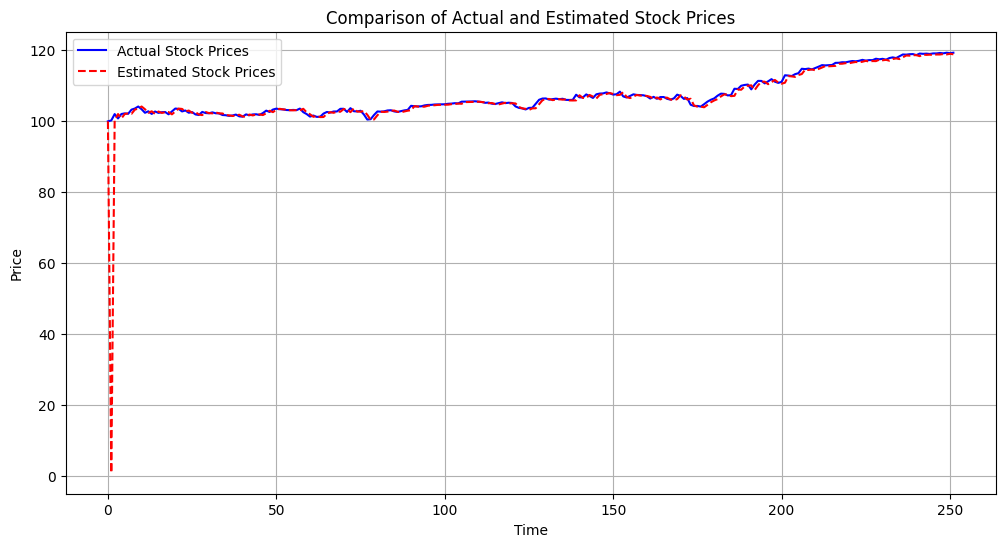

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(Stock_price_jump, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [59]:
guess_mu = 0.1
guess_kappa = 1.0
guess_theta = 0
guess_sigma = 0.1
guess_rho = 0
lambda_ = 8
j = 0.1

In [60]:
time_start = time.time()
u, v, estimates, like = extended_kalman_parameters_bates(log_stock_prices, N, guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho, lambda_, j)
time_end = time.time()
print("running time (s):    ", time_end-time_start)

running time (s):     0.008831024169921875


In [61]:
rmse = np.sqrt(mean_squared_error(Stock_price_jump, np.exp(estimates)))
rmse

6.278050464938908

In [62]:
result = minimize(negative_log_jump_likelihood, x0=[guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho, lambda_, j],bounds =[[0,1], [1,2], [0, 0.5],[0, 0.5], [-1, 0], [4,6],[0,0.5]] , method="L-BFGS-B",tol=1e-12)

In [63]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1589.248087482038
        x: [ 1.000e-01  1.000e+00  7.791e-08  1.000e-01 -2.164e-07
             6.000e+00  1.000e-01]
      nit: 3
      jac: [ 1.774e+08 -3.043e+08 -3.209e+08 -1.100e+08  1.359e+08
            -4.074e+08  1.504e+08]
     nfev: 200
     njev: 25
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

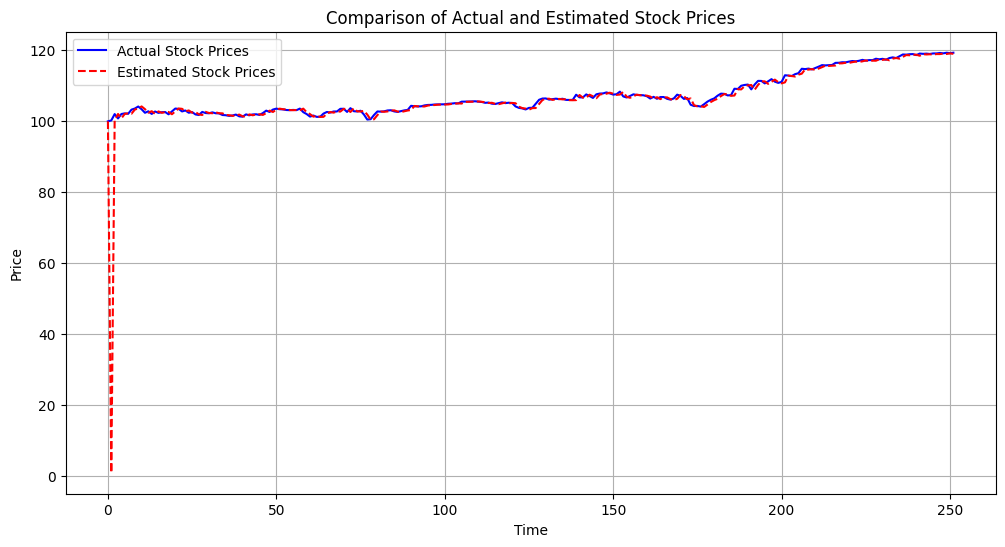

In [64]:
plt.figure(figsize=(12, 6))
plt.plot(Stock_price_jump, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
mu = 0.05
kappa = 1.0
theta = 0.02
sigma = 0.1
rho = -0.9
T = 1.0
N = 252
S0 = 100
v0 = 0.04
time_ = list(range(1, N+1))

## Solve Particle Extend Kalman Filter in Bates

In [66]:
def particle_extended_kalman_filter_bates(log_stock_prices, muS, omega, theta, xi, rho, lambda_, j):

    n_stock_prices = len(log_stock_prices)
    M = 1000
    delt = 1.0 / N
    A = 1.0 - (theta - 0.5 * rho * xi) * delt
    H = -0.5 * delt
    x0 = 0.04
    P0 = 0.000001
    x = np.random.normal(x0, np.sqrt(P0), M)
    mu = np.zeros(M)
    P = np.full(M, P0)
    ll = 0.0
    estimates = np.zeros(n_stock_prices)

    for i1 in range(1, n_stock_prices-1):
        l = 0.0
        x1_sum = 0.0
        m1_sum = 0.0
        x1 = np.zeros(M)
        x2 = np.zeros(M)
        P1 = np.zeros(M)
        W = np.zeros(M)
        K = np.zeros(M)
        xx = np.zeros(M)
        mm = np.zeros(M)
        w = np.zeros(M)
        c = np.zeros(M)
        m1 = mu.copy()
        m2 = np.zeros(M)

        for i2 in range(M):
            # EKF for the proposal distribution
            x[i2] = max(x[i2], 0.00001)
            x1[i2] = x[i2] + (omega - rho * xi * (muS + lambda_ * j) - (theta - 0.5 * rho * xi) * x[i2]) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1-1]) - rho * xi * mu[i2]
            x1[i2] = max(x1[i2], 0.00001)

            W[i2] = xi * np.sqrt((1 - rho**2) * x[i2] * delt)
            P1[i2] = W[i2]**2 + A * P[i2] * A

            U = np.sqrt(x1[i2] * delt)
            K[i2] = P1[i2] * H / (H * P1[i2] * H + U**2)
            z = log_stock_prices[i1+1]

            x2[i2] = x1[i2] + K[i2] * (z - (log_stock_prices[i1] + (muS + lambda_ * j - 0.5 * x1[i2]) * delt + m1[i2]))
            P[i2] = (1.0 - K[i2] * H) * P1[i2]
            xx[i2] = x2[i2] + np.sqrt(P[i2]) * norm.ppf(np.random.random())
            xx[i2] = max(xx[i2], 0.00001)
            mm[i2] = np.log(1.0 - j) if np.random.random() < np.exp(-lambda_ * delt) else 0.0

            m = x2[i2]
            s = np.sqrt(P[i2])
            q = 0.39894228 / s * np.exp(-0.5 * (xx[i2] - m)**2 / s**2)

            m = log_stock_prices[i1] + (muS + lambda_ * j - 0.5 * xx[i2]) * delt + mm[i2]
            s = np.sqrt(xx[i2] * delt)
            pz = 0.39894228 / s * np.exp(-0.5 * (z - m)**2 / s**2)

            m = x[i2] + (omega - rho * xi * (muS + lambda_ * j) - (theta - 0.5 * rho * xi) * x[i2]) * delt + rho * xi * (log_stock_prices[i1] - log_stock_prices[i1-1]) - rho * xi * mu[i2]
            s = xi * np.sqrt((1 - rho**2) * x[i2] * delt)
            px = 0.39894228 / s * np.exp(-0.5 * (xx[i2] - m)**2 / s**2)

            w[i2] = pz * px / max(q, 1.0e-10)
            l += w[i2]
            x1_sum += x1[i2]
            m1_sum += m1[i2]

        ll += np.log(l)
        estimates[i1+1] = log_stock_prices[i1] + (muS + lambda_ * j - 0.5 * x1_sum / M) * delt + m1_sum / M

        # normalize weights
        w /= l
        # resample and reset weights
        c = np.cumsum(w)
        u = np.linspace(0, 1-1/M, M) + 1.0/M * np.random.random()
        indices = np.searchsorted(c, u)
        x = xx[indices]
        mu = mm[indices]
        w = np.full(M, 1.0/M)

    ll *= -1.0
    return ll, estimates


In [67]:
log_stock_prices = np.log(Stock_price_jump)

In [68]:
ll, estimates = particle_extended_kalman_filter_bates(log_stock_prices, mu, kappa, theta, xi, rho, lambda_ = 5, j = 0.2)

In [69]:
rmse = np.sqrt(mean_squared_error(Stock_price_jump, np.exp(estimates)))
rmse

9.278433410892434

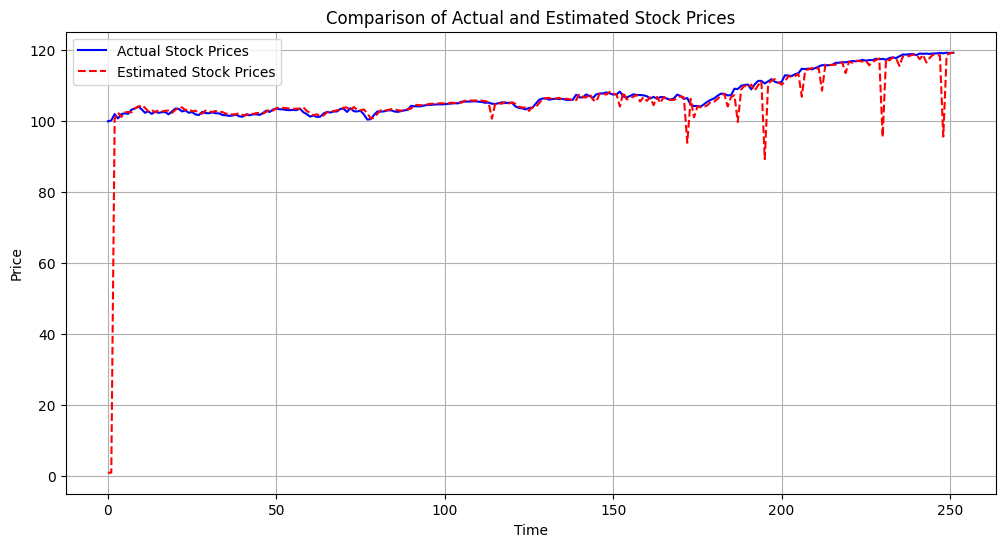

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(Stock_price_jump, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
guess_mu = 0.1
guess_kappa = 1.0
guess_theta = 0
guess_sigma = 0.1
guess_rho = 0
lambda_ = 8
j = 0.1

In [72]:
time_start = time.time()
l, estimates = particle_extended_kalman_filter_bates(log_stock_prices, guess_mu, guess_kappa, guess_theta, guess_sigma, guess_rho, lambda_, j)
time_end = time.time()
print("running time (s):    ", time_end-time_start)

running time (s):     35.37386631965637


In [73]:
rmse = np.sqrt(mean_squared_error(Stock_price_jump, np.exp(estimates)))
rmse

11.545247457362079

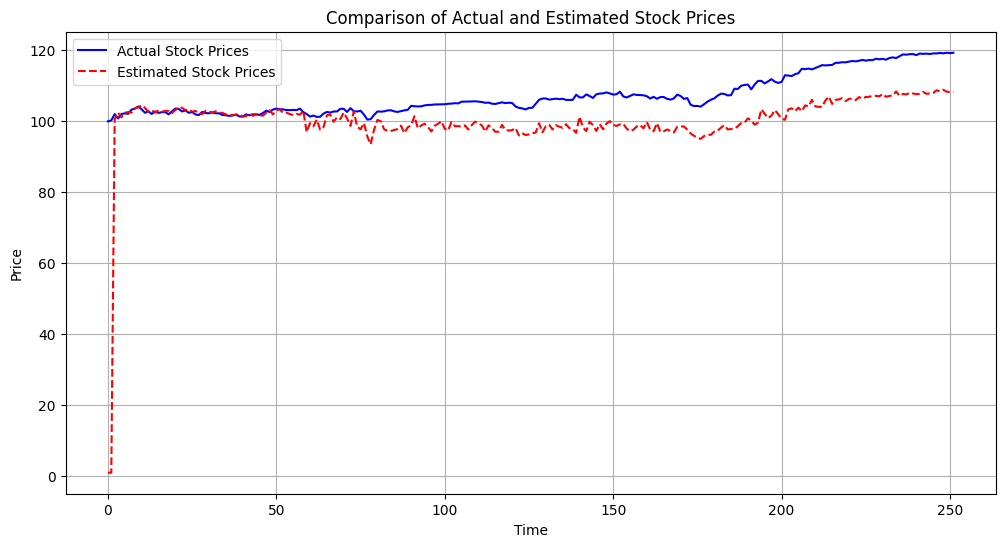

In [74]:
plt.figure(figsize=(12, 6))
plt.plot(Stock_price_jump, label='Actual Stock Prices', color='blue')
plt.plot(np.exp(estimates), label='Estimated Stock Prices', color='red', linestyle='--')
plt.title('Comparison of Actual and Estimated Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()